# Import Packages

In [1]:
#!pip install seaborn livelossplot

%matplotlib inline

import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics, optimizers
from livelossplot import PlotLosses

def set_random_seed_tf(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

SEED = 42    
set_random_seed_tf(SEED)

2022-07-31 12:16:27.249705: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# 1. Load dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 2. Preprocessing

In [3]:
x_train, x_test = x_train / 255, x_test / 255
x_train = x_train[..., None].astype("float32")  # (B, H, W) -> (B, H, W, 1)
x_test  = x_test[..., None].astype('float32')

In [4]:
INPUT_SHAPE  = x_train[0].shape
OUTPUT_SHAPE = 1
N_CLASSES    = len(np.unique(y_train))

print("- Training(X, y):", x_train.shape, y_train.shape)
print("- Test(X, y):", x_test.shape, y_test.shape)
print("- Number of classes:", N_CLASSES)

- Training(X, y): (60000, 28, 28, 1) (60000,)
- Test(X, y): (10000, 28, 28, 1) (10000,)
- Number of classes: 10


In [5]:
def generate_dataset_tf(X, y=None, batch_size=32, shuffle=True):
    """Generate TensorFlow dataset from array-like data (X, y)

    Parameters
    ----------
    X : array-like
        Input data

    y : numpy.ndarray (default=None)
        Output data

    batch_size : int (default=32)
        Batch size

    shuffle : bool (default=True)
        Whether to shuffle data

    Returns
    -------
    TensorFlow dataset : tf.data.Dataset
        Generated dataset
    """
    # 1. Convert dtype to float32
    X = np.array(X, dtype=np.float32)
    if y is not None:
        y = np.array(y, dtype=np.float32)

    # 2. Generate TensorFlow dataset
    if y is None:
        ds = tf.data.Dataset.from_tensor_slices(X)
    else:
        ds = tf.data.Dataset.from_tensor_slices((X, y))

    # 3. Options
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    return ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

train_ds = generate_dataset_tf(x_train, y_train)
test_ds = generate_dataset_tf(x_test, y_test)

2022-07-31 12:16:29.220873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-31 12:16:29.226979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-31 12:16:29.227347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-31 12:16:29.227678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

# 3. Modeling

In [6]:
FILTERS = 32
KERNEL_SIZE = 3
UNITS   = 128

def get_model(filters, kernel_size, units, n_classes, input_shape):
    inputs = keras.Input(input_shape)
    x = layers.Conv2D(filters, kernel_size, activation='relu')(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(units, activation='relu')(x)
    outputs = layers.Dense(n_classes)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


model = get_model(FILTERS, KERNEL_SIZE, UNITS, N_CLASSES, INPUT_SHAPE)

loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True)  # (true, pred)
optimizer = optimizers.Adam()

train_loss = metrics.Mean(name='train_loss')
train_acc  = metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = metrics.Mean(name='test_loss')
test_acc  = metrics.SparseCategoricalAccuracy(name='test_accuracy')

model.build(x_train.shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 128)               2769024   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


# 4. Training

In [7]:
def reset_metrics(*metrics):
    for metric in metrics:
        metric.reset_states()
        
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_acc(labels, predictions)
    
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_fn(labels, predictions)
    test_loss(t_loss)
    test_acc(labels, predictions)

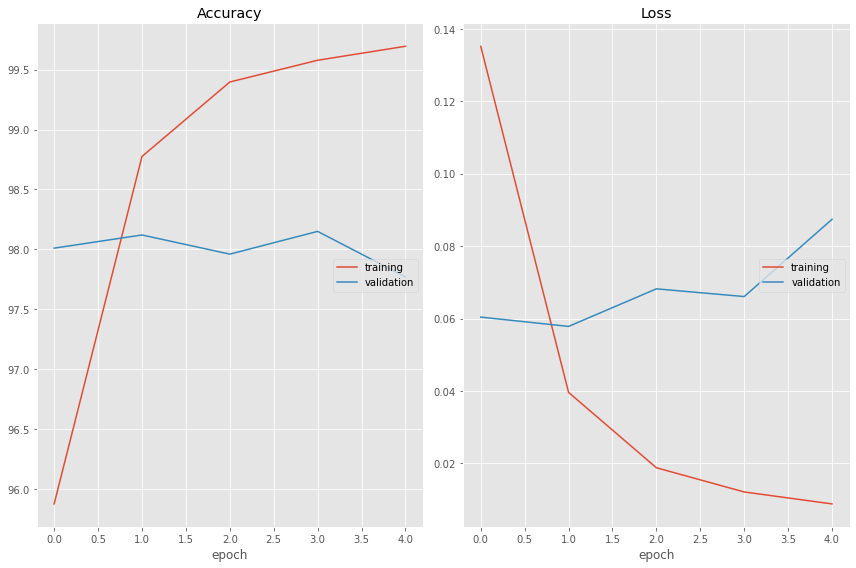

100%|██████████| 5/5 [01:33<00:00, 18.71s/it]

Accuracy
	training         	 (min:   95.875, max:   99.695, cur:   99.695)
	validation       	 (min:   97.770, max:   98.150, cur:   97.770)
Loss
	training         	 (min:    0.009, max:    0.135, cur:    0.009)
	validation       	 (min:    0.058, max:    0.087, cur:    0.087)


In [8]:
EPOCHS = 5
liveloss = PlotLosses()

for epoch in tqdm(range(EPOCHS)):
    reset_metrics(train_loss, train_acc, test_loss, test_acc)
    
    for images, labels in train_ds:
        train_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    liveloss.update({'loss': train_loss.result(),
                     'val_loss': test_loss.result(),
                     'acc': train_acc.result()*100,
                     'val_acc': test_acc.result()*100})
    liveloss.send()